# Traffic Data Analysis

This is a preliminary analysis of traffic crash data made available at 
https://opendata-nzta.opendata.arcgis.com/datasets/crash-analysis-system-cas-data-1/explore?location=-9.510847%2C0.000000%2C2.92.

The dataset examined here was obtained from the csv download "Crash_Analysis_System_(CAS)_data.csv"

Note that this dataset is not static, therefore its contents may have changed since the time it was downloaded for the purpose of this analysis.

The goal is to
- Characterize the dataset.
- Discern some basic characteristics of crash metrics contained in the dataset.
- Potentially determine the dataset features that are most important in distinguishing between injury crashes and non-injury crashes.


In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#### Determine basic statistics for each column

In [3]:
# Define function to determine basic statistics for the dataframe columns, 
def get_dataset_stats(df, exclude=["excluded_col_1","excluded_col_2"], round_digits=3):
    """
    PARAMETERS:
        df - A dataframe
        exclude - a list of columns names within df to exclude from the analysis
    RETURNS: a dataframe with basic statistics for each column in df, including counts of null values
    """

    # Create list of columns to analyze.
    include_columns = list(df.columns)
    for element in exclude:
        if element in include_columns:
            include_columns.remove(element)
    
    
    types_df = pd.DataFrame(df[include_columns].dtypes).rename({0:"dtype"}, axis=1)
    obj_list = df[include_columns].select_dtypes(include=['object']).columns.to_list()
    # local function to resolve atomic datatypes for 'object' columns:
    def get_obj_type(df, var):
        type = ""
        if df[var].isnull().all():
            type = 'none'
        else:
            try:
                df[var].astype("datetime64[ns]")
                type = 'datetime64[ns]'
            except:
                try:
                    df[var].astype("int64")
                    type = 'int64'
                except:
                    try:
                        df[var].astype("float64")
                        type = 'float64'  
                    except:
                        try:
                            df[var].astype("str")
                            type = 'str'
                        except:
                            type = 'str'
                            pass
        return type    
    
    for col in obj_list:
        new_type = get_obj_type(df, col)
        print("{} new type is {}".format(col, new_type))
        types_df["dtype"][col] = new_type
    
    
    dg = pd.DataFrame(np.nan, index=include_columns, 
                      columns=["type","excluded","non_null_count","nullcnt","%nulls","min",
                               "pcntl25","median","mean","pcntl75","max",
                               "stddev","str-maxlen","str-meanlen","str-medianlen","str-minlen","ndistinct"])
    
    try:
        for varname in include_columns:
            if str(types_df["dtype"][varname]) in ["datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]"]:
                df[varname] = df[varname].dt.tz_localize(None)
                types_df["dtype"][varname] = "datetime64[ns]"
                
            dg.type.loc[varname] = types_df.loc[varname, "dtype"]
            if dg.type.loc[varname] == 'float64':
                df[varname] = df[varname].astype('float')
            elif dg.type.loc[varname] == 'int64':
                df[varname] = df[varname].astype('int')
            if varname in exclude:
                dg.loc[varname,"excluded"] = 'Yes'
            else:
                dg.loc[varname,"excluded"] = 'No'
            # print("Var: {}  Type: {}".format(varname, dg.type.loc[varname]))
            dg.loc[varname,"ndistinct"] = df[varname].nunique()

            if types_df["dtype"][varname] in ["float64","int64","int32","datetime64[ns]","str","none"]:
                dg.loc[varname, "nullcnt"] = df[varname].isna().sum().astype(int)
                totalcnt = df[varname].count().astype(int) + dg.loc[varname, "nullcnt"]
                dg.loc[varname,"non_null_count"] = totalcnt - dg.loc[varname, "nullcnt"]
                dg.loc[varname,"%nulls"] = (100.0 * dg.loc[varname,"nullcnt"] / totalcnt).round(decimals=2)
            if types_df["dtype"][varname] in ["datetime64[ns]"]:
                dg.loc[varname,"min"] = df[varname].dropna().min()
                dg.loc[varname,"max"] = df[varname].dropna().max()
                dg.loc[varname,"mean"] = df[varname].dropna().mean()
            elif types_df["dtype"][varname] in ["float64","int64","int32"]:
                dg.loc[varname,"min"] = round(df[varname].dropna().min(), round_digits)
                dg.loc[varname,"max"] = round(df[varname].dropna().max(), round_digits)
                dg.loc[varname,"mean"] = round(df[varname].dropna().mean(), round_digits)                
            if types_df["dtype"][varname] in ["float64","int64","int32"]:
                dg.loc[varname,"pcntl25"] = round(df[varname].dropna().quantile(0.25), round_digits)
                dg.loc[varname,"median"] = round(df[varname].dropna().quantile(0.5), round_digits) 
                dg.loc[varname,"pcntl75"] = round(df[varname].dropna().quantile(0.75), round_digits)
                dg.loc[varname,"stddev"] = round(df[varname].dropna().std(), round_digits)
            if types_df["dtype"][varname] in ["str"] and varname not in exclude:
                dg.loc[varname,"str-maxlen"] = df[varname].str.len().max()
                dg.loc[varname,"str-meanlen"] = df[varname].str.len().mean()
                dg.loc[varname,"str-medianlen"] = df[varname].str.len().median()
                dg.loc[varname,"str-minlen"] = df[varname].str.len().min()
                           
    except:
        print("Failed iteration on variable: {}".format(varname))
    
    return dg

In [4]:
# Define working directories
data_dir = "../data"
output_dir = "../outputs"
os.chdir(data_dir)
#os.getcwd()

In [5]:
# Load data
df = pd.read_csv("Crash_Analysis_System_(CAS)_data.csv")

In [6]:
# Set the current directory for outputs (plots, etc.).
os.chdir(output_dir)
#os.getcwd()

In [7]:
df.head(60)

,X,Y,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,crashLocation2,crashRoadSideRoad,crashSeverity,crashSHDescription,crashYear,debris,directionRoleDescription,ditch,fatalCount,fence,flatHill,guardRail,holiday,houseOrBuilding,intersection,kerb,light,meshblockId,minorInjuryCount,moped,motorcycle,NumberOfLanes,objectThrownOrDropped,otherObject,otherVehicleType,overBank,parkedVehicle,pedestrian,phoneBoxEtc,postOrPole,region,roadCharacter,roadLane,roadSurface,roadworks,schoolBus,seriousInjuryCount,slipOrFlood,speedLimit,strayAnimal,streetLight,suv,taxi,temporarySpeedLimit,tlaId,tlaName,trafficControl,trafficIsland,trafficSign,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,1.772561e+06,5.896382e+06,1,NaN,525420.0,0.0,NaN,0.0,1.0,NaN,Null,2007/2008,EAST ST,ELLIOT ST,NaN,Non-Injury Crash,No,2007,NaN,North,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Dark,791600.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,On,1.0,0.0,NaN,76.0,Auckland,Traffic Signals,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
1,1.836757e+06,5.859311e+06,3,NaN,534300.0,0.0,NaN,0.0,2.0,NaN,Null,2002/2003,SH 2,SH 26,NaN,Non-Injury Crash,Yes,2003,NaN,North,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Dark,1073700.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Waikato Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,On,0.0,0.0,NaN,12.0,Hauraki District,Give way,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Frost
2,1.762088e+06,5.912507e+06,4,NaN,519500.0,0.0,NaN,0.0,1.0,NaN,West,2009/2010,CHURCH ST,HUGO JOHNSTON DRIVE,NaN,Non-Injury Crash,No,2010,NaN,East,NaN,0.0,NaN,Flat,NaN,Queens Birthday,NaN,NaN,NaN,Bright sun,622400.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Off,0.0,0.0,NaN,76.0,Auckland,Traffic Signals,NaN,NaN,NaN,NaN,0.0,0.0,Urban,1.0,NaN,NaN,Fine,Null
3,1.753522e+06,5.911939e+06,6,NaN,518902.0,0.0,NaN,0.0,2.0,NaN,Null,2017/2018,THE AVENUE,ACCESSWAY,NaN,Minor Crash,No,2017,NaN,North,NaN,0.0,NaN,Hill Road,NaN,NaN,NaN,NaN,NaN,Overcast,587500.0,1.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Null,0.0,0.0,NaN,76.0,Auckland,Nil,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Light rain,Null
4,1.761364e+06,5.914259e+06,7,NaN,520202.0,0.0,NaN,0.0,2.0,NaN,Null,2017/2018,PENROSE INT,GT SOUTH LINK,NaN,Non-Injury Crash,No,2018,NaN,North,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Overcast,612300.0,0.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Motorway ramp,1-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Null,0.0,0.0,NaN,76.0,Auckland,Give way,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
5,1.803464e+06,5.815043e+06,9,NaN,530500.0,0.0,NaN,0.0,3.0,NaN,North,2009/2010,KNIGHTON ROAD,HELENA ROAD,NaN,Minor Crash,No,2010,NaN,South,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Overcast,891500.0,1.0,0.0,0.0,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Waikato Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,Off,0.0,0.0,NaN,16.0,Hamilton City,Nil,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
6,1.749964e+06,5.914060e+06,11,NaN,511303.0,0.0,NaN,0.0,1.0,NaN,Null,2013/2014,GREAT NORTH ROAD,MEMORIAL DRIVE,NaN,Non-Injury Crash,No,2014,NaN,South,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Dark,266000.0,0.0,0.0,0.0,4.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Auckland Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,On,0.0,0.0,NaN,76.0,Auckland,Traffic Signals,NaN,NaN,NaN,NaN,1.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
7,1.572762e+06,5.178572e+06,14,NaN,594200.0,1.0,NaN,0.0,1.0,NaN,Null,2010/2011,ENSORS ROAD,MACKENZIE AVENUE,NaN,Minor Crash,No,2010,NaN,West,NaN,0.0,NaN,Flat,NaN,NaN,NaN,NaN,NaN,Dark,2581400.0,1.0,0.0,0.0,4.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Canterbury Region,Nil,2-way,Sealed,NaN,0.0,0.0,NaN,50.0,NaN,On,0.0,0.0,NaN,60.0,Christchurch City,Give way,NaN,NaN,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
8

In [8]:
# Obtain basic information: field names, datatypes, non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776878 entries, 0 to 776877
Data columns (total 72 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   X                          776878 non-null  float64
 1   Y                          776878 non-null  float64
 2   OBJECTID                   776878 non-null  int64  
 3   advisorySpeed              29289 non-null   float64
 4   areaUnitID                 776762 non-null  float64
 5   bicycle                    776873 non-null  float64
 6   bridge                     310482 non-null  float64
 7   bus                        776873 non-null  float64
 8   carStationWagon            776873 non-null  float64
 9   cliffBank                  310482 non-null  float64
 10  crashDirectionDescription  776878 non-null  object 
 11  crashFinancialYear         776878 non-null  object 
 12  crashLocation1             776878 non-null  object 
 13  crashLocation2             77

In [9]:
# Produce basic statistical report. Determine viable atomic types for those columns of 'object' Dtype.
df_stats = get_dataset_stats(df)


crashDirectionDescription new type is str
crashFinancialYear new type is str
crashLocation1 new type is str
crashLocation2 new type is str
crashSeverity new type is str
crashSHDescription new type is str
directionRoleDescription new type is str
flatHill new type is str
holiday new type is str
light new type is str
region new type is str
roadCharacter new type is str
roadLane new type is str
roadSurface new type is str
streetLight new type is str
tlaName new type is str
trafficControl new type is str
urban new type is str
weatherA new type is str
weatherB new type is str


D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
# Display computed column metrics for dataframe.
df_stats

,type,excluded,non_null_count,nullcnt,%nulls,min,pcntl25,median,mean,pcntl75,max,stddev,str-maxlen,str-meanlen,str-medianlen,str-minlen,ndistinct
X,float64,No,776878.0,0.0,0.00,1150346.0,1704491.50,1757273.000,1720811.722,1792725.00,2465388.404,153587.370,NaN,NaN,NaN,NaN,300896.0
Y,float64,No,776878.0,0.0,0.00,4793921.0,5433734.00,5803817.226,5644636.177,5914008.00,6190095.000,330871.527,NaN,NaN,NaN,NaN,337344.0
OBJECTID,int64,No,776878.0,0.0,0.00,1.0,318535.25,637330.000,637114.897,955793.75,1274097.000,367820.479,NaN,NaN,NaN,NaN,776878.0
advisorySpeed,float64,No,29289.0,747589.0,96.23,10.0,40.00,55.000,54.504,65.00,95.000,18.213,NaN,NaN,NaN,NaN,18.0
areaUnitID,float64,No,776762.0,116.0,0.01,500100.0,519200.00,536630.000,546213.268,573526.00,626801.000,32591.674,NaN,NaN,NaN,NaN,1875.0
bicycle,float64,No,776873.0,5.0,0.00,0.0,0.00,0.000,0.029,0.00,5.000,0.171,NaN,NaN,NaN,NaN,6.0
bridge,float64,No,310482.0,466396.0,60.03,0.0,0.00,0.000,0.014,0.00,4.000,0.118,NaN,NaN,NaN,NaN,5.0
bus,float64,No,776873.0,5.0,0.00,0.0,0.00,0.000,0.016,0.00,3.000,0.127,NaN,NaN,NaN,NaN,4.0
carStationWagon,float64,No,776873.0,5.0,0.00,0.0,1.00,1.000,1.320,2.00,11.000,0.784,NaN,NaN,NaN,NaN,12.0
cliffBank,float64,No,310482.0,466396.0,60.03,0.0,0.00,0.000,0.106,0.00,3.000,0.309,NaN,NaN,NaN,NaN,4.0


In [11]:
# Determine measures that have no non-null values. These could be dropped, since they provide no information, 
# however we will keep them to retain the original frame structure.
df_stats[df_stats["non_null_count"] == 0]

,type,excluded,non_null_count,nullcnt,%nulls,min,pcntl25,median,mean,pcntl75,max,stddev,str-maxlen,str-meanlen,str-medianlen,str-minlen,ndistinct
crashRoadSideRoad,float64,No,0.0,776878.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
intersection,float64,No,0.0,776878.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Find all values for low-cardinality str columns.

(a) Let's check whether the actual value ranges align with those declared in the field descriptions.
    Of special interest will be nulls, NaNs or obvious proxies for these.
    
(b) Some of these features may be candidates for one-hot-encoding if ML is applied on this dataset.

(c) We have arbitrarily set the "low cardinality" threshold to 60, though in practice most string columns of interest have
    fewer distinct values, as can be seen from the column statistics.

In [12]:
distinct_vals = pd.DataFrame(data=None, columns=['Variable', 'Value','Count'])
cardinality_thrsld = 60
for col in df_stats[df_stats.type == 'str'][df_stats.ndistinct < cardinality_thrsld].index.values.tolist():
    for val in df[col].unique():
        if pd.isna(val):
            count = len(df[df[col].isnull()]) # Count the occurrence of NaN values if applicable within this column
        else:
            count = len(df[df[col] == val]) # Count the occurrence of this value within this column
        # Append to dataframe
        distinct_vals.loc[len(distinct_vals)] = [col, val, count]

distinct_vals

<ipython-input-12-19e224c3b594>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for col in df_stats[df_stats.type == 'str'][df_stats.ndistinct < cardinality_thrsld].index.values.tolist():


,Variable,Value,Count
0,crashDirectionDescription,Null,292055
1,crashDirectionDescription,West,95492
2,crashDirectionDescription,North,145423
3,crashDirectionDescription,South,149361
4,crashDirectionDescription,East,94547
5,crashFinancialYear,2007/2008,41119
6,crashFinancialYear,2002/2003,38093
7,crashFinancialYear,2009/2010,37209
8,crashFinancialYear,2017/2018,39583
9,crashFinancialYear,2013/2014,29965


This can aid in decisions about imputing or dropping missing data, where relevant. For example, region shows 3026 cases with value NaN. This may imply either absence of information about the region, or it may imply locations that legitimately lie outside any region. In some contexts it may be valid to treat these as a category; in others to drop these records.
Similar considerations apply to other cases where NaN appears as a value for a categorical variable.

In [13]:
# For the above cases, 'Null' and 'Nil' are probably equivalent. For 'region', NaN might be better recoded 
# to a specific value such as 'Other', since the absence of a region may have some useful meaning. 
# It's not clear that we want to retain data for 'Other' since we will be focusing on defined major regions.
df['region'].fillna('Other',inplace=True)

In [14]:
# Did this work?
len(df[df['region'].isnull()]) # 0 is good.

0

In [15]:
# The one record having NaN value in 'crashSHDescription' is well formed. We ASSUME the value is probably equivalent 
# to 'Unknown'.
df[df['crashSHDescription'].isnull()]

,X,Y,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,crashLocation2,crashRoadSideRoad,crashSeverity,crashSHDescription,crashYear,debris,directionRoleDescription,ditch,fatalCount,fence,flatHill,guardRail,holiday,houseOrBuilding,intersection,kerb,light,meshblockId,minorInjuryCount,moped,motorcycle,NumberOfLanes,objectThrownOrDropped,otherObject,otherVehicleType,overBank,parkedVehicle,pedestrian,phoneBoxEtc,postOrPole,region,roadCharacter,roadLane,roadSurface,roadworks,schoolBus,seriousInjuryCount,slipOrFlood,speedLimit,strayAnimal,streetLight,suv,taxi,temporarySpeedLimit,tlaId,tlaName,trafficControl,trafficIsland,trafficSign,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
560970,1.836611e+06,5.866924e+06,920329,NaN,NaN,0.0,0.0,0.0,1.0,0.0,South,2019/2020,026-0070,ROBINSON ROAD,NaN,Serious Crash,NaN,2019,0.0,South,1.0,0.0,0.0,Flat,0.0,NaN,0.0,NaN,0.0,Dark,NaN,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,Other,Nil,2-way,Sealed,0.0,0.0,1.0,0.0,100.0,0.0,None,0.0,0.0,NaN,NaN,NaN,Unknown,0.0,0.0,0.0,1.0,0.0,0.0,Open,0.0,0.0,0.0,Fine,Null


In [16]:
df['crashSHDescription'].fillna('Unknown',inplace=True)

In [17]:
len(df[df['crashSHDescription'].isnull()]) # 0 is good.

0

In [18]:
# Similarly for 'directionRoleDescription', NaN is probably equivalent to 'Null'.
df['directionRoleDescription'].fillna('Null',inplace=True)

In [19]:
len(df[df['directionRoleDescription'].isnull()]) # 0 is good.

0

## General observations of dataset

1. The granularity of date / time observations is 1 year (calendar or financial).
   This would preclude detailed time series analysis of (for example) seasonal, weekly, or diurnal effects.
   
2. Depending on the specific subject of analysis, it may be expedient to relate these data to external datasets. Explicit      joins to other geodata may be possible via the coordinates or via the 'crashLocation1' and 'crashLocation2' fields, the    MeshblockID, and the Region.

3. The field descriptions at https://opendata-nzta.opendata.arcgis.com/pages/cas-data-field-descriptions do not list          'intersection' or 'crashSideRoad'. However, although these columns appear in the crash dataset, they contain no non-null    values.

   Although listed in the field descriptions, 'junctionType' and 'intersectionMidblock' does not appear in the dataset.        
   The 'northing' and 'easting' variables listed in the field descriptions do not appear in the downloaded CSV dataset.
   
   Could it be that these are excluded from the CSV download, but included in geoJson or KML downloads?



### Crash counts by region by year.
For the present purposes we will exclude data without a defined region, i.e. that we have marked as region = 'Other'.

In [20]:
# Create a dataframe that shows the total crashes by year for each region.

crashes_by_region_by_year = pd.DataFrame(
{'region': ['Northland Region','Auckland Region', 'Waikato Region', 'Bay of Plenty Region', 'Gisborne Region',
                'Hawke\'s Bay Region', 'Taranaki Region', 'Manawatū-Whanganui Region',
                'Wellington Region', 'Tasman Region', 'Nelson Region', 'Marlborough Region',
                'West Coast Region', 'Canterbury Region', 'Otago Region', 'Southland Region']})

for i in range(df['crashYear'].min(), df['crashYear'].max()):
    x = pd.DataFrame(df[df['crashYear'] == i]['region'].value_counts().rename(str(i), inplace=True))
    x.reset_index(inplace=True)
    x.rename(columns={"index":"region"}, inplace=True)
    crashes_by_region_by_year = crashes_by_region_by_year.merge(x, how='left', on='region')

crashes_by_region_by_year.rename(columns={"region":"Region"}, inplace=True)
crashes_by_region_by_year

,Region,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Northland Region,1015,1120,1236,1552,1540,1450,1543,1630,1560,1550,1441,1224,1216,1193,1265,1366,1501,1670,1841,1670,1547
1,Auckland Region,12285,13670,14811,14445,13426,13588,13763,13887,13548,12866,12753,11259,10865,10686,10640,11442,13308,13787,12631,11788,9839
2,Waikato Region,2749,3638,3465,3652,3678,4170,4307,4282,3909,3826,3770,3548,3226,3041,3134,3549,3989,4688,4692,4477,3923
3,Bay of Plenty Region,1336,1741,1951,2267,2143,2281,2296,2314,2096,2208,2081,1942,1630,1633,1564,1799,2267,2296,2366,2445,2135
4,Gisborne Region,319,435,450,416,450,480,446,423,503,519,506,394,347,363,295,284,362,387,485,466,507
5,Hawke's Bay Region,1236,1318,1435,1565,1643,1730,1611,1844,1554,1562,1502,1249,1029,1045,998,1002,1340,1388,1478,1465,1439
6,Taranaki Region,761,804,839,784,755,810,841,995,965,923,856,805,716,670,602,675,742,779,839,844,819
7,Manawatū-Whanganui Region,1984,2038,2237,2067,1997,2087,2047,1972,1901,1806,2027,1917,1717,1644,1671,1828,1900,2188,2210,2209,2163
8,Wellington Region,3197,3225,3218,3063,3374,3455,4037,4881,4488,4114,3827,2852,2731,2968,2745,2919,3617,3956,3835,3656,3210
9,Tasman Region,296,295,321,385,349,289,310,374,349,338,297,310,263,290,213,259,359,449,390,375,343


In [21]:
# Create a molten (long-form) equivalent of the above for ease of plotting.
values=[str(i) for i in range(df['crashYear'].min(), df['crashYear'].max())]
crashes_by_region_by_year_long = crashes_by_region_by_year.melt(
    id_vars=['Region'], 
    value_vars=values, var_name='year', value_name='crash_count')

crashes_by_region_by_year_long.head(6)

,Region,year,crash_count
0,Northland Region,2000,1015
1,Auckland Region,2000,12285
2,Waikato Region,2000,2749
3,Bay of Plenty Region,2000,1336
4,Gisborne Region,2000,319
5,Hawke's Bay Region,2000,1236


#### Plot total crashes by region by year

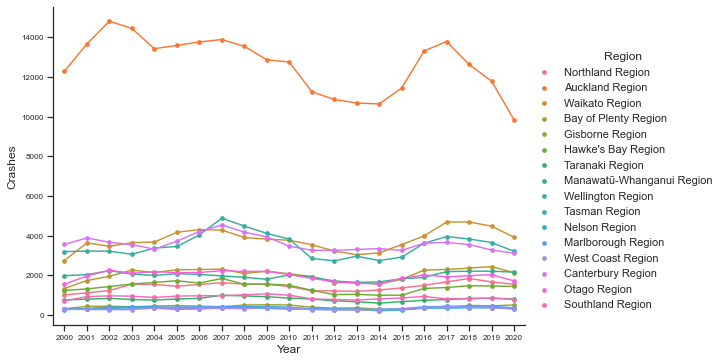

In [22]:
sns.set(style="ticks", rc={"lines.linewidth": 0.8, "xtick.labelsize":8, "ytick.labelsize":8})
g = sns.catplot(x="year", y="crash_count", hue='Region', legend_out=True,
                data=crashes_by_region_by_year_long, kind='point', height=5, aspect=1.5,
               palette="husl")
g.set_axis_labels("Year", "Crashes")
g.savefig('Crashes per Year by Region.png')

### Population by region based on the 2018 Census
These population counts by region from the 2018 Census were sourced from
https://www.stats.govt.nz/tools/2018-census-place-summaries/?gclid=EAIaIQobChMI8Pb9wbOK9wIV7ZNmAh3KMgDxEAAYASAAEgIgqfD_BwE.
The population of 'Other' is assumed to be zero.

In [23]:
pop_by_region_2018 = {
    'region' : ['Northland Region','Auckland Region', 'Waikato Region', 'Bay of Plenty Region', 'Gisborne Region',
                'Hawke\'s Bay Region', 'Taranaki Region', 'Manawatū-Whanganui Region',
                'Wellington Region', 'Tasman Region', 'Nelson Region', 'Marlborough Region',
                'West Coast Region', 'Canterbury Region', 'Otago Region', 'Southland Region'],
    'population_2018' : [179076, 1571718, 458202, 308499, 47517, 
                    166368, 117561, 238797, 
                    506814, 52389, 50880, 47340,
                    31575, 599694, 225186, 97467]
}

pop_df = pd.DataFrame(pop_by_region_2018)
# Rescale the population counts to 1000's and round to 2 significant digits
pop_df['population_2018'] = pop_df['population_2018'].div(1000).round(2)
pop_df.head()

,region,population_2018
0,Northland Region,179.08
1,Auckland Region,1571.72
2,Waikato Region,458.20
3,Bay of Plenty Region,308.50
4,Gisborne Region,47.52


In [24]:
crashes_by_region_2018 = pd.DataFrame(df[df['crashYear'] == 2018]['region'].value_counts().rename("crash_count_2018", inplace=True))
crashes_by_region_2018.reset_index(inplace=True)
crashes_by_region_2018.rename(columns={"index":"region"}, inplace=True)
crashes_by_region_2018.head(16)

,region,crash_count_2018
0,Auckland Region,12631
1,Waikato Region,4692
2,Wellington Region,3835
3,Canterbury Region,3551
4,Bay of Plenty Region,2366
5,Manawatū-Whanganui Region,2210
6,Otago Region,1979
7,Northland Region,1841
8,Hawke's Bay Region,1478
9,Taranaki Region,839


In [25]:
dg = pd.merge(left=crashes_by_region_2018, right=pop_df, on='region', how='inner')
#dg = pd.merge(left=dg, right=pop_df, on='region', how='inner')
dg.sort_values(by='population_2018', ascending=False, inplace=True)

# Determine the ratio of crashes to population.
dg['crash_to_pop_ratio'] = (dg['crash_count_2018'] / dg['population_2018']).round(2)
dg.head()

,region,crash_count_2018,population_2018,crash_to_pop_ratio
0,Auckland Region,12631,1571.72,8.04
3,Canterbury Region,3551,599.69,5.92
2,Wellington Region,3835,506.81,7.57
1,Waikato Region,4692,458.20,10.24
4,Bay of Plenty Region,2366,308.50,7.67


In [26]:
# What is the average crash_to_pop_ratio?
print("The mean crash-to-population-ratio among all regions is {}".format(dg['crash_to_pop_ratio'].mean()))

The mean crash-to-population-ratio among all regions is 8.643125


Create a normalized variant of this ratio, to make for easier recognition of where each region lies on the distribution.

In [27]:
crash_to_pop_array = np.array(dg['crash_to_pop_ratio']).reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(crash_to_pop_array)
std_crash_to_pop_array = scaler.transform(crash_to_pop_array)

dg['std_crash_to_pop_array'] = std_crash_to_pop_array
dg.head()

,region,crash_count_2018,population_2018,crash_to_pop_ratio,std_crash_to_pop_array
0,Auckland Region,12631,1571.72,8.04,-0.407586
3,Canterbury Region,3551,599.69,5.92,-1.840261
2,Wellington Region,3835,506.81,7.57,-0.725207
1,Waikato Region,4692,458.20,10.24,1.079152
4,Bay of Plenty Region,2366,308.50,7.67,-0.657628


### Compare crash counts by region with population

### Hypothesis

- The volumes of crashes by region is probably broadly proportional to the regional population. 

Let's check this, assuming that the population distribution across the regions has remained roughly consistent over time. (A precise analysis is not intended here.)

In [28]:
# Reorder the data by descending crash counts.
dg.sort_values(by='crash_count_2018', ascending=False, inplace=True)

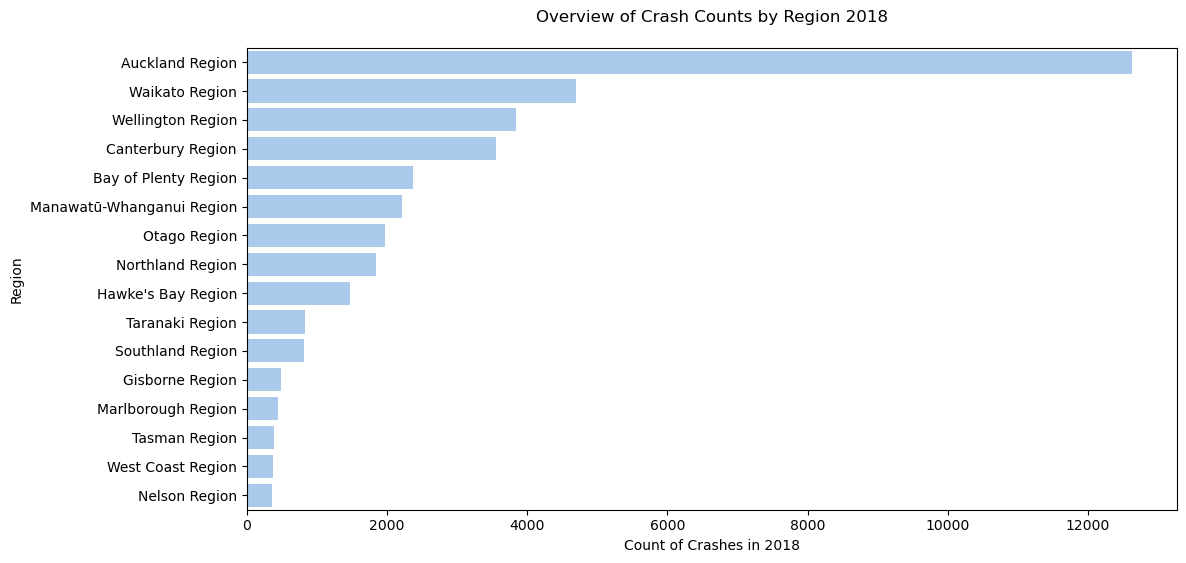

In [29]:
mpl.rc_file_defaults()
#mpl.rcParams['agg.path.chunksize'] = 10000
sns.set_color_codes("pastel")
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = dg, x='crash_count_2018', y='region', 
            ci=None, ax=ax1, color='b').set_title('Overview of Crash Counts by Region 2018\n')
ax1.set(xlabel='Count of Crashes in 2018', ylabel='Region')

#ax2 = ax1.twiny()
#sns.lineplot(data = dg[['population_2018','region']], x='population_2018', y='region', marker='o', sort = False, ax=ax2, color='r')
#ax2.set(xlabel='Regional Population from 2018 Census (Thousands)')

fig.savefig('Crash Counts by Region 2018.png')


As expected, the Auckland region dominates the absolute crash count.
Now let's compare regions on the basis of crashes per unit of population. There are obviously many reasons why this could yield a different result.
Because we have summarized population data by region only from the 2018 Census, we will use only the crash data from this year, acknowledging that the results may well be time-variant.

In [30]:
# Reorder the dataframe so that regions with highest crash ratio appear at the top.
dg.sort_values(by='crash_to_pop_ratio', ascending=False, inplace=True)

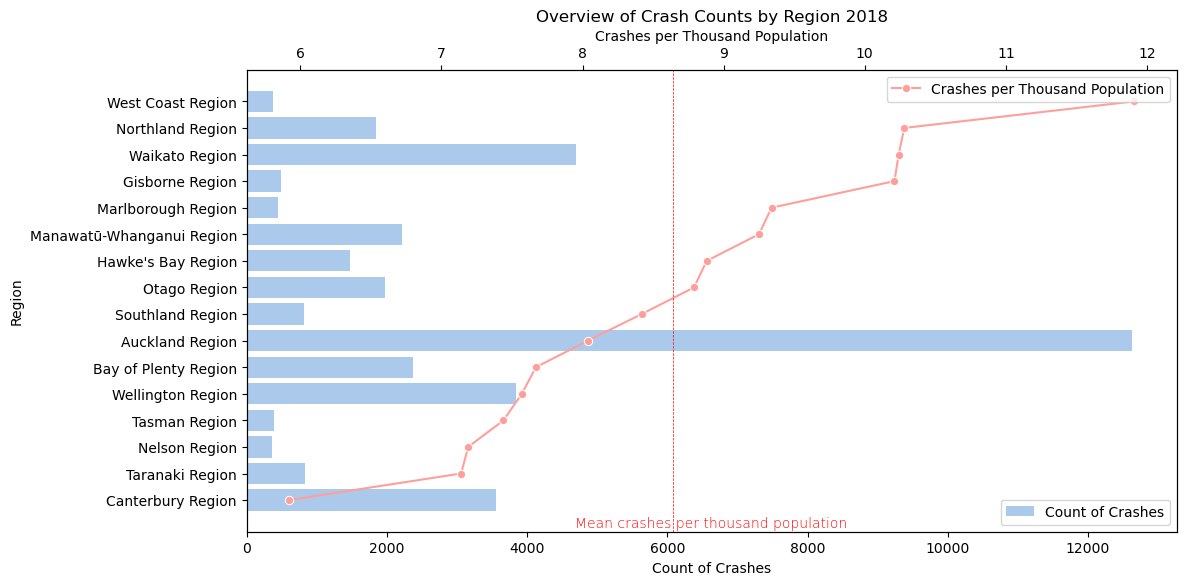

In [31]:
sns.set_color_codes("pastel")
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = dg, x='crash_count_2018', y='region', 
            ci=None, ax=ax1, color='b').set_title('Overview of Crash Counts by Region 2018')
ax1.set(xlabel='Count of Crashes', ylabel='Region')
ax1.legend(labels=['Count of Crashes'], loc=4)

ax2 = ax1.twiny()
sns.lineplot(data = dg[['crash_to_pop_ratio','region']], x='crash_to_pop_ratio', y='region', marker='o', sort = False, ax=ax2, color='r')
ax2.set(xlabel='Crashes per Thousand Population')
ax2.legend(labels=['Crashes per Thousand Population'], loc=1)

ax2.axvline(x=dg['crash_to_pop_ratio'].mean(), color='red', ls='--', lw=0.5)
ax2.text(7.95, 16, "Mean crashes per thousand population", 
         horizontalalignment='left', size='medium', color='red', weight='light')

plt.show()
fig.savefig("Overview of Crash Counts by Population 2018.png")

### Observations
The purpose of this display is to assess visually whether the total number of reported crashes by region is broadly consistent with population. We focus here only on the 2018 crash data to ensure consistency. The graph shows the regions in decreasing order of the ratio of crashes to regional population.

- The regional population is definitely not the whole story, i.e. although there is a broad relationship between the regional population and the number of crashes reported. 

- The std_crash_to_pop_array indicates that in 2018, the West Coast was somewhat an outlier in respect of the crash rates by population. Northland, Waikato, and Gisborne had rather higher than average rates.

- By contrast, Canterbury exhibited a lower than average rate. And despite dominating the crash statistics in absolute terms, Auckland's crash rates relative to population size were below average.

- The significance of this metric may be questionable for regions with relatively low crash and / or population counts.


Speculations: 
- Are tourists disproportionately represented in crash statistics in those regions most dependent on tourism? (West Coast would surely be such a region.)
 
- Do longer average trips raise the likelihood of crashes? Intuitively seems plausible.
 
- Is there a clear rural / urban split, either nationwide or in specific regions?
 
- Is "typical" terrain relevant? e.g. Canterbury has a lot of flat terrain and straight roads.

Further investigation possibilities:

- Analyze the frequencies of occurrence of other dataset parameters in crash records, and compare regions to gain insight.

- Check for more localized clustering of crashes in different regions, and observe whether specific localities are relative "black spots" that dominate the statistics in certain regions. 

- It might be instructive to analyze down to Area Units. (AUs) The AU names could be substituted by However, these values have not remained static over the lifetime of this crash dataset, and have been replaced (since 2018) by SA2s, which are not necessarily geographically consistent with AUs, and do not have the same identifier codes. This entails complications that are best avoided for the present exercise.

## Can we find a model to relate dataset features to Crash Severity values?
The purpose is to see which features, if any, are most important in determining crash severity.

- Most of the usable predictors are categorical variables.

- Assume that "minor crashes" involve injury in some degree.



### How unbalanced is the dataset, i.e. what is the ratio of counts for each Crash Severity outcome to the total?

In [32]:
cs = pd.DataFrame(df['crashSeverity'].value_counts())
cs.reset_index(inplace=True)
cs.rename(columns={"crashSeverity":"count", "index":"crashSeverity"}, inplace=True)
cs['percent_of_total'] = (cs['count'] * 100 / sum(cs['count'])).round(2)
cs

,crashSeverity,count,percent_of_total
0,Non-Injury Crash,546781,70.38
1,Minor Crash,179089,23.05
2,Serious Crash,43893,5.65
3,Fatal Crash,7115,0.92


To predict fatal crashes, or "fatal and serious" crashes would be a quite unbalanced predictive problem. Let's adopt a more balanced derived binary outcome - Minor, Serious, and Fatal crashes taken together as one outcome, and Non-Injury crashes as the other.

- We are treating crashSeverity as a labelled outcome.

- Some of the predictors are explicitly used to obtain the crashSeverity outcomes: "This is determined by the worst injury sustained in the crash at time of entry."

- Creating a new derived 'injuryStatus' outcome as follows yields a far more balanced outcome set.

In [140]:
# How balanced would a derived binary outcome look?.
map_dict = {'Non-Injury Crash':'Non-Injury Crash', 'Minor Crash':'Injury Crash',
            'Fatal Crash':'Injury Crash', 'Serious Crash':'Injury Crash'}
y1 = df['crashSeverity'].map(map_dict)
ct = pd.DataFrame(y1.value_counts())
ct.reset_index(inplace=True)
ct.rename(columns={"crashSeverity":"count", "index":"injuryStatus"}, inplace=True)
ct['percent_of_total'] = (ct['count'] * 100 / sum(ct['count'])).round(2)
ct

,injuryStatus,count,percent_of_total
0,Non-Injury Crash,546781,70.38
1,Injury Crash,230097,29.62


In [137]:


y
ct = pd.DataFrame(df['crashSeverity'].value_counts())
cs.reset_index(inplace=True)
cs.rename(columns={"crashSeverity":"count", "index":"crashSeverity"}, inplace=True)
cs['percent_of_total'] = (cs['count'] * 100 / sum(cs['count'])).round(2)
cs


Non-Injury Crash    546781
Injury Crash        230097
Name: crashSeverity, dtype: int64

In [ ]:
ct.rename(columns={"crashSeverity":"count", "index":"crashSeverity"}, inplace=True)
ct['percent_of_total'] = (cs['count'] * 100 / sum(cs['count'])).round(2)
ct

### Preprocess the dataset.

In [33]:
# Drop the following variables explicitly
drop_these = [
    'X',
    'Y',
    'OBJECTID',
    'fatalCount',    # likely too closely correlated to crashSeverity -- would be cheating
    'advisorySpeed', # Too sparse
    'areaUnitID',    # Cardinality too high to encode usefully. Leave Region in.
    'meshblockId',   # As above.
    'tlaId',         # As above.
    'tlaName',       # As above.
    'crashFinancialYear', # Leave it out and keep crashYear
    'crashRoadSideRoad',  # All nulls
    'crashLocation1',  # Cardinality too high to encode usefully.
    'crashLocation2',  # Cardinality too high to encode usefully.
    'intersection',  # All nulls in this set, but seems like an important predictor in principle.
    'minorInjuryCount', # Not independent of crashSeverity -- cheating
    'seriousInjuryCount', # Not independent of crashSeverity -- cheating
]

In [34]:
df.drop(drop_these, axis=1, inplace=True)

In [35]:
cont_features = list(df.columns[df.dtypes == 'float64'])

In [36]:
# Classify the feature types based on dtype (as a starting point).
integer_features = list(df.columns[df.dtypes == 'int32'])
cont_features = list(df.columns[df.dtypes == 'float64'])
categorical_features = list(df.columns[df.dtypes == 'object'])

In [37]:
integer_features

['crashYear']

In [38]:
cont_features

['bicycle',
 'bridge',
 'bus',
 'carStationWagon',
 'cliffBank',
 'debris',
 'ditch',
 'fence',
 'guardRail',
 'houseOrBuilding',
 'kerb',
 'moped',
 'motorcycle',
 'NumberOfLanes',
 'objectThrownOrDropped',
 'otherObject',
 'otherVehicleType',
 'overBank',
 'parkedVehicle',
 'pedestrian',
 'phoneBoxEtc',
 'postOrPole',
 'roadworks',
 'schoolBus',
 'slipOrFlood',
 'speedLimit',
 'strayAnimal',
 'suv',
 'taxi',
 'temporarySpeedLimit',
 'trafficIsland',
 'trafficSign',
 'train',
 'tree',
 'truck',
 'unknownVehicleType',
 'vanOrUtility',
 'vehicle',
 'waterRiver']

In [39]:
categorical_features

['crashDirectionDescription',
 'crashSeverity',
 'crashSHDescription',
 'directionRoleDescription',
 'flatHill',
 'holiday',
 'light',
 'region',
 'roadCharacter',
 'roadLane',
 'roadSurface',
 'streetLight',
 'trafficControl',
 'urban',
 'weatherA',
 'weatherB']

In [40]:
# Impute missing values in numerical features to avoid value errors in model. Choose mean to avoid skew.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df[cont_features])
df[cont_features] = imp.transform(df[cont_features])

In [41]:
crashDirectionDescription = list(df.crashDirectionDescription.unique())
crashDirectionDescription

['Null', 'West', 'North', 'South', 'East']

In [42]:
crashSHDescription = list(df.crashSHDescription.unique())
crashSHDescription

['No', 'Yes', 'Unknown']

In [43]:
directionRoleDescription = list(df.directionRoleDescription.unique())
directionRoleDescription

['North', 'East', 'South', 'West', 'Null']

In [44]:
flatHill = list(df.flatHill.unique())
flatHill

['Flat', 'Hill Road', 'Null']

In [45]:
# Lets make nan become 'Null'
df['holiday'].fillna('Null',inplace=True)
holiday = list(df.holiday.unique())
holiday

['Null', 'Queens Birthday', 'Christmas New Year', 'Easter', 'Labour Weekend']

In [46]:
light = list(df.light.unique())
light

['Dark', 'Bright sun', 'Overcast', 'Unknown', 'Twilight']

In [62]:
region = list(df.region.unique())
region

['Auckland Region',
 'Waikato Region',
 'Canterbury Region',
 'Northland Region',
 'Bay of Plenty Region',
 'Manawatū-Whanganui Region',
 'Otago Region',
 'Wellington Region',
 "Hawke's Bay Region",
 'Southland Region',
 'West Coast Region',
 'Nelson Region',
 'Taranaki Region',
 'Other',
 'Tasman Region',
 'Gisborne Region',
 'Marlborough Region']

In [47]:
roadCharacter = list(df.roadCharacter.unique())
roadCharacter

['Nil',
 'Motorway ramp',
 'Bridge',
 'Overpass',
 'Rail xing',
 'Speed hump',
 'Underpass',
 'Tunnel',
 'Tram lines']

In [48]:
roadLane = list(df.roadLane.unique())
roadLane

['2-way', '1-way', 'Off road', 'Null']

In [49]:
roadSurface = list(df.roadSurface.unique())
roadSurface

['Sealed', 'Unsealed', 'Null', 'End of seal']

In [50]:
streetLight = list(df.streetLight.unique())
streetLight

['On', 'Off', 'Null', 'None']

In [51]:
trafficControl = list(df.trafficControl.unique())
trafficControl

['Traffic Signals',
 'Give way',
 'Nil',
 'Unknown',
 'Stop',
 'School Patrol/warden',
 'Isolated Pedestrian signal (non-intersection)',
 'Pointsman']

In [52]:
urban = list(df.urban.unique())
urban

['Urban', 'Open']

In [53]:
weatherA = list(df.weatherA.unique())
weatherA

['Fine',
 'Light rain',
 'Null',
 'Mist or Fog',
 'Heavy rain',
 'Snow',
 'Hail or Sleet']

In [54]:
weatherB = list(df.weatherB.unique())
weatherB

['Null', 'Frost', 'Strong wind', 'None']

In [55]:
# One-hot-encode crashDirectionDescription
crashDirectionDescription_df = pd.DataFrame(crashDirectionDescription, columns=["crashDirectionDescription"])
dum_df = pd.get_dummies(crashDirectionDescription_df, columns=["crashDirectionDescription"], prefix=["crashDirectionDescription"])
crashDirectionDescription_df = crashDirectionDescription_df.join(dum_df)
crashDirectionDescription_df

,crashDirectionDescription,crashDirectionDescription_East,crashDirectionDescription_North,crashDirectionDescription_Null,crashDirectionDescription_South,crashDirectionDescription_West
0,Null,0,0,1,0,0
1,West,0,0,0,0,1
2,North,0,1,0,0,0
3,South,0,0,0,1,0
4,East,1,0,0,0,0


In [56]:
# One-hot-encode crashSHDescription
crashSHDescription_df = pd.DataFrame(crashSHDescription, columns=["crashSHDescription"])
dum_df = pd.get_dummies(crashSHDescription_df, columns=["crashSHDescription"], prefix=["crashSHDescription"])
crashSHDescription_df = crashSHDescription_df.join(dum_df)
crashSHDescription_df

,crashSHDescription,crashSHDescription_No,crashSHDescription_Unknown,crashSHDescription_Yes
0,No,1,0,0
1,Yes,0,0,1
2,Unknown,0,1,0


In [57]:
# One-hot-encode directionRoleDescription
directionRoleDescription_df = pd.DataFrame(directionRoleDescription, columns=["directionRoleDescription"])
dum_df = pd.get_dummies(directionRoleDescription_df, columns=["directionRoleDescription"], prefix=["directionRoleDescription"])
directionRoleDescription_df = directionRoleDescription_df.join(dum_df)
directionRoleDescription_df

,directionRoleDescription,directionRoleDescription_East,directionRoleDescription_North,directionRoleDescription_Null,directionRoleDescription_South,directionRoleDescription_West
0,North,0,1,0,0,0
1,East,1,0,0,0,0
2,South,0,0,0,1,0
3,West,0,0,0,0,1
4,Null,0,0,1,0,0


In [58]:
# One-hot-encode flatHill
flatHill_df = pd.DataFrame(flatHill, columns=["flatHill"])
dum_df = pd.get_dummies(flatHill_df, columns=["flatHill"], prefix=["flatHill"])
flatHill_df = flatHill_df.join(dum_df)
flatHill_df

,flatHill,flatHill_Flat,flatHill_Hill Road,flatHill_Null
0,Flat,1,0,0
1,Hill Road,0,1,0
2,Null,0,0,1


In [59]:
# One-hot-encode holiday
holiday_df = pd.DataFrame(holiday, columns=["holiday"])
dum_df = pd.get_dummies(holiday_df, columns=["holiday"], prefix=["holiday"])
holiday_df = holiday_df.join(dum_df)
holiday_df

,holiday,holiday_Christmas New Year,holiday_Easter,holiday_Labour Weekend,holiday_Null,holiday_Queens Birthday
0,Null,0,0,0,1,0
1,Queens Birthday,0,0,0,0,1
2,Christmas New Year,1,0,0,0,0
3,Easter,0,1,0,0,0
4,Labour Weekend,0,0,1,0,0


In [60]:
# One-hot-encode light
light_df = pd.DataFrame(light, columns=["light"])
dum_df = pd.get_dummies(light_df, columns=["light"], prefix=["light"])
light_df = light_df.join(dum_df)
light_df

,light,light_Bright sun,light_Dark,light_Overcast,light_Twilight,light_Unknown
0,Dark,0,1,0,0,0
1,Bright sun,1,0,0,0,0
2,Overcast,0,0,1,0,0
3,Unknown,0,0,0,0,1
4,Twilight,0,0,0,1,0


In [63]:
# One-hot-encode region
region_df = pd.DataFrame(region, columns=["region"])
dum_df = pd.get_dummies(region_df, columns=["region"], prefix=["region"])
region_df = region_df.join(dum_df)
region_df

,region,region_Auckland Region,region_Bay of Plenty Region,region_Canterbury Region,region_Gisborne Region,region_Hawke's Bay Region,region_Manawatū-Whanganui Region,region_Marlborough Region,region_Nelson Region,region_Northland Region,region_Otago Region,region_Other,region_Southland Region,region_Taranaki Region,region_Tasman Region,region_Waikato Region,region_Wellington Region,region_West Coast Region
0,Auckland Region,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Waikato Region,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Canterbury Region,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Northland Region,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Bay of Plenty Region,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Manawatū-Whanganui Region,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,Otago Region,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,Wellington Region,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,Hawke's Bay Region,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,Southland Region,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [64]:
# One-hot-encode roadCharacter
roadCharacter_df = pd.DataFrame(roadCharacter, columns=["roadCharacter"])
dum_df = pd.get_dummies(roadCharacter_df, columns=["roadCharacter"], prefix=["roadCharacter"])
roadCharacter_df = roadCharacter_df.join(dum_df)
roadCharacter_df

,roadCharacter,roadCharacter_Bridge,roadCharacter_Motorway ramp,roadCharacter_Nil,roadCharacter_Overpass,roadCharacter_Rail xing,roadCharacter_Speed hump,roadCharacter_Tram lines,roadCharacter_Tunnel,roadCharacter_Underpass
0,Nil,0,0,1,0,0,0,0,0,0
1,Motorway ramp,0,1,0,0,0,0,0,0,0
2,Bridge,1,0,0,0,0,0,0,0,0
3,Overpass,0,0,0,1,0,0,0,0,0
4,Rail xing,0,0,0,0,1,0,0,0,0
5,Speed hump,0,0,0,0,0,1,0,0,0
6,Underpass,0,0,0,0,0,0,0,0,1
7,Tunnel,0,0,0,0,0,0,0,1,0
8,Tram lines,0,0,0,0,0,0,1,0,0


In [65]:
# One-hot-encode roadLane
roadLane_df = pd.DataFrame(roadLane, columns=["roadLane"])
dum_df = pd.get_dummies(roadLane_df, columns=["roadLane"], prefix=["roadLane"])
roadLane_df = roadLane_df.join(dum_df)
roadLane_df

,roadLane,roadLane_1-way,roadLane_2-way,roadLane_Null,roadLane_Off road
0,2-way,0,1,0,0
1,1-way,1,0,0,0
2,Off road,0,0,0,1
3,Null,0,0,1,0


In [66]:
# One-hot-encode roadSurface
roadSurface_df = pd.DataFrame(roadSurface, columns=["roadSurface"])
dum_df = pd.get_dummies(roadSurface_df, columns=["roadSurface"], prefix=["roadSurface"])
roadSurface_df = roadSurface_df.join(dum_df)
roadSurface_df

,roadSurface,roadSurface_End of seal,roadSurface_Null,roadSurface_Sealed,roadSurface_Unsealed
0,Sealed,0,0,1,0
1,Unsealed,0,0,0,1
2,Null,0,1,0,0
3,End of seal,1,0,0,0


In [67]:
# One-hot-encode streetLight
streetLight_df = pd.DataFrame(streetLight, columns=["streetLight"])
dum_df = pd.get_dummies(streetLight_df, columns=["streetLight"], prefix=["streetLight"])
streetLight_df = streetLight_df.join(dum_df)
streetLight_df

,streetLight,streetLight_None,streetLight_Null,streetLight_Off,streetLight_On
0,On,0,0,0,1
1,Off,0,0,1,0
2,Null,0,1,0,0
3,None,1,0,0,0


In [68]:
# One-hot-encode trafficControl
trafficControl_df = pd.DataFrame(trafficControl, columns=["trafficControl"])
dum_df = pd.get_dummies(trafficControl_df, columns=["trafficControl"], prefix=["trafficControl"])
trafficControl_df = trafficControl_df.join(dum_df)
trafficControl_df

,trafficControl,trafficControl_Give way,trafficControl_Isolated Pedestrian signal (non-intersection),trafficControl_Nil,trafficControl_Pointsman,trafficControl_School Patrol/warden,trafficControl_Stop,trafficControl_Traffic Signals,trafficControl_Unknown
0,Traffic Signals,0,0,0,0,0,0,1,0
1,Give way,1,0,0,0,0,0,0,0
2,Nil,0,0,1,0,0,0,0,0
3,Unknown,0,0,0,0,0,0,0,1
4,Stop,0,0,0,0,0,1,0,0
5,School Patrol/warden,0,0,0,0,1,0,0,0
6,Isolated Pedestrian signal (non-intersection),0,1,0,0,0,0,0,0
7,Pointsman,0,0,0,1,0,0,0,0


In [69]:
# One-hot-encode urban
urban_df = pd.DataFrame(urban, columns=["urban"])
dum_df = pd.get_dummies(urban_df, columns=["urban"], prefix=["urban"])
urban_df = urban_df.join(dum_df)
urban

['Urban', 'Open']

In [70]:
# One-hot-encode weatherA
weatherA_df = pd.DataFrame(weatherA, columns=["weatherA"])
dum_df = pd.get_dummies(weatherA_df, columns=["weatherA"], prefix=["weatherA"])
weatherA_df = weatherA_df.join(dum_df)
weatherA_df

,weatherA,weatherA_Fine,weatherA_Hail or Sleet,weatherA_Heavy rain,weatherA_Light rain,weatherA_Mist or Fog,weatherA_Null,weatherA_Snow
0,Fine,1,0,0,0,0,0,0
1,Light rain,0,0,0,1,0,0,0
2,Null,0,0,0,0,0,1,0
3,Mist or Fog,0,0,0,0,1,0,0
4,Heavy rain,0,0,1,0,0,0,0
5,Snow,0,0,0,0,0,0,1
6,Hail or Sleet,0,1,0,0,0,0,0


In [71]:
# One-hot-encode weatherB
weatherB_df = pd.DataFrame(weatherB, columns=["weatherB"])
dum_df = pd.get_dummies(weatherB_df, columns=["weatherB"], prefix=["weatherB"])
weatherB_df = weatherB_df.join(dum_df)
weatherB_df

,weatherB,weatherB_Frost,weatherB_None,weatherB_Null,weatherB_Strong wind
0,Null,0,0,1,0
1,Frost,1,0,0,0
2,Strong wind,0,0,0,1
3,None,0,1,0,0


In [72]:
# Merge one-hot-encode variables into the dataset.
df = pd.merge(df, crashDirectionDescription_df, how='left', on='crashDirectionDescription', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('crashDirectionDescription', axis=1)

In [73]:
df = pd.merge(df, crashSHDescription_df, how='left', on='crashSHDescription', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('crashSHDescription', axis=1)

In [74]:
df = pd.merge(df, directionRoleDescription_df, how='left', on='directionRoleDescription', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('directionRoleDescription', axis=1)

In [75]:
df = pd.merge(df, flatHill_df, how='left', on='flatHill', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('flatHill', axis=1)

In [76]:
df = pd.merge(df, holiday_df, how='left', on='holiday', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('holiday', axis=1)

In [77]:
df = pd.merge(df, light_df, how='left', on='light', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('light', axis=1)

In [78]:
df = pd.merge(df, region_df, how='left', on='region', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('region', axis=1)

In [79]:
df = pd.merge(df, roadCharacter_df, how='left', on='roadCharacter', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('roadCharacter', axis=1)

In [80]:
df = pd.merge(df, roadLane_df, how='left', on='roadLane', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('roadLane', axis=1)

In [81]:
df = pd.merge(df, roadSurface_df, how='left', on='roadSurface', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('roadSurface', axis=1)

In [82]:
df = pd.merge(df, streetLight_df, how='left', on='streetLight', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('streetLight', axis=1)

In [83]:
df = pd.merge(df, trafficControl_df, how='left', on='trafficControl', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('trafficControl', axis=1)

In [84]:
df = pd.merge(df, urban_df, how='left', on='urban', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('urban', axis=1)

In [85]:
df = pd.merge(df, weatherA_df, how='left', on='weatherA', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('weatherA', axis=1)

In [86]:
df = pd.merge(df, weatherB_df, how='left', on='weatherB', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=False, indicator=False).drop('weatherB', axis=1)

In [88]:
# Save coded dataframe as csv.
#df.to_csv('encoded_dataframe.csv')

In [89]:
# Check for any nulls
df.columns[df.isnull().any()] # Good, none.

Index([], dtype='object')

In [90]:
# Include a dummy randomised normal variate
df['donkey'] = np.random.normal(0, 1, len(df))

In [92]:
df.crashSeverity.unique()

array(['Non-Injury Crash', 'Minor Crash', 'Fatal Crash', 'Serious Crash'],
      dtype=object)

In [94]:
# Create a new derived binary label from crashSeverity.
map_dict = {'Non-Injury Crash':'Non-Injury Crash', 'Minor Crash':'Injury Crash',
            'Fatal Crash':'Injury Crash', 'Serious Crash':'Injury Crash'}
y0 = df['crashSeverity']
y1 = df['crashSeverity'].map(map_dict)

In [97]:
df.drop(['crashSeverity'], axis=1, inplace=True)
X = df # Assign new name to df

In [98]:
# Split into predictors matrix and outcomes vector
# We don't need to retain key fields because we don't want to make specific predictions.
y = y1

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [101]:
# Train a random forest classifier on the training set
clf = RandomForestClassifier(n_estimators=20, random_state=0, max_depth=10, 
                             class_weight='balanced_subsample', max_features=len(X_train.columns))
clf.fit(X_train, y_train.values.ravel())


y_pred = clf.predict(X_test)

In [102]:
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

    Injury Crash       0.47      0.68      0.56     75790
Non-Injury Crash       0.83      0.68      0.75    180580

        accuracy                           0.68    256370
       macro avg       0.65      0.68      0.65    256370
    weighted avg       0.73      0.68      0.69    256370



The model is not superb, yet not diabolical. The precision pertinent to the Injury Crash class is less than 0.5. This could probably be improved at the expense of reduced recall by applying undersampling / oversampling strategies.

It seems reasonable that many factors not contained within the dataset contribute to injuries.

In [110]:
# Print the impurity-based feature importances
# Print the feature ranking
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
donkey_index = 0

print("Feature ranking:")
print("---------------")

for f in range(X_train.shape[1]):
    if X_train.columns[indices[f]] == 'donkey':
        donkey_index = f
        break
    print("%d. %s\t(%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
---------------
1. pedestrian	(0.219002)
2. bicycle	(0.174812)
3. motorcycle	(0.174764)
4. speedLimit	(0.170368)
5. moped	(0.054799)
6. roadLane_1-way	(0.030085)
7. parkedVehicle	(0.029615)
8. carStationWagon	(0.029001)
9. crashYear	(0.023797)
10. tree	(0.014854)
11. weatherA_Null	(0.013879)
12. NumberOfLanes	(0.012381)
13. cliffBank	(0.010850)
14. postOrPole	(0.005990)
15. debris	(0.004723)
16. region_Canterbury Region	(0.003664)


In [111]:
donkey_index

16

In [118]:
importances_gt_donkey = importances[indices[0:donkey_index]]

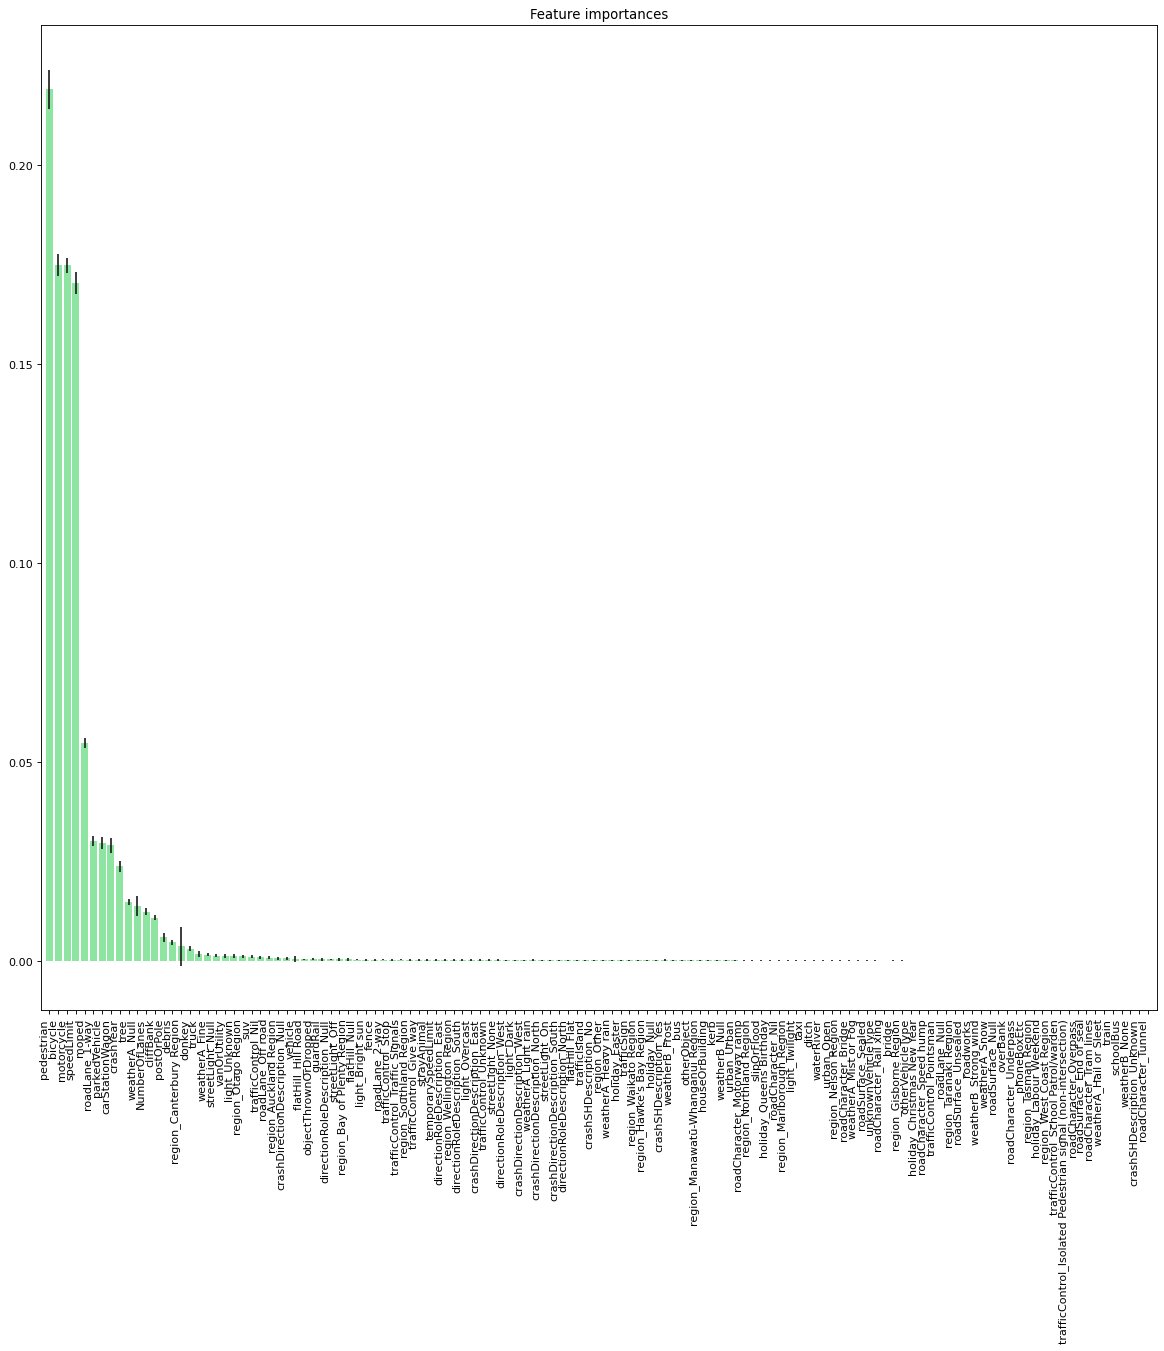

In [120]:
# Plot the forest's impurity-based feature importances

# Plot the forest's impurity-based feature importances

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), labels=X_train.columns[indices])

#plt.xticks(range(X_train.shape[1]), indices)
plt.xticks(rotation=90, ha='right')
plt.xlim([-1, X_train.shape[1]])
 

plt.show()
fig.savefig("Impurity-based Feature Importances.png")

The numerical features most likely dominate the impurity-based feature importances since they are leass sparse than the one-hot-encoded categoricals. Let's try permutation feature importances (this is a lot more compute-intensive).

In [123]:
perm = PermutationImportance(clf, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0562 ± 0.0004,speedLimit
0.0317 ± 0.0001,pedestrian
0.0237 ± 0.0003,bicycle
0.0201 ± 0.0001,motorcycle
0.0159 ± 0.0003,roadLane_1-way
0.0055 ± 0.0001,moped
0.0042 ± 0.0002,debris
0.0038 ± 0.0002,crashYear
0.0035 ± 0.0002,carStationWagon
0.0011 ± 0.0004,NumberOfLanes


Of the features within the dataset, the ones that contribute most to explaining the difference between injury and non-injury crashes are:
- speedLimit
- pedestrian
- bicycle
- motorcycle

Perhaps it is intuitive that higher speeds result in more dangerous crashes. Colliding with pedestrians, bicycles, and motorcycles also seems consistent with injuries.